# Nonlinear Elasticity in a multipatch domain


In [39]:
# Here both, constant load over x-axis(length) and user-defined load possible!

In [40]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

from geo_annulus import *
from plots import *
#from ass_nonlin_el import *
from solver import *
from line_search import *


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['bmat', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [41]:
# 3 D #
p = 3 # spline degree
multi= 1
n_el = (4, 2, 2)  # number of elements in x, y, z direction, isotropic material
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)


In [42]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

def plot_geo(geo, grid=10, gridx=None, gridy=None, gridz= None,
             res=30,
             linewidth=None, color='black',  **kwargs):
    """Plot a wireframe representation of a 2D geometry."""
    #fig = plt.figure()
    
    if geo.sdim == 1 and geo.dim == 2:
        print("plot_curve")
        return plot_curve(geo, res=res, linewidth=linewidth, color=color)
    
    if geo.dim == geo.sdim == 2:
        #assert geo.dim == geo.sdim == 2, 'Can only plot 2D geometries'
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        supp = geo.support

        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotline(pts, capstyle='butt'):
            plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=linewidth,
                     solid_joinstyle='round', solid_capstyle=capstyle)

        pts = grid_eval(geo, (gridx, meshy))
        plotline(pts[0, :, :], capstyle='round')
        for i in range(1, pts.shape[0] - 1):
            plotline(pts[i, :, :])
        plotline(pts[-1, :, :], capstyle='round')

        pts = grid_eval(geo, (meshx, gridy))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

    
    if geo.sdim == geo.dim == 3:
        #print("3D geometry")
        # syntax for 3-D projection
        #ax = plt.axes(projection ='3d')
        #assert geo.dim == geo.sdim == 3, 'Can only plot 3D geometries'
        
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotline(pts, capstyle='butt'):
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap=cm.coolwarm, linewidth=linewidth,  **kwargs)

        pts = grid_eval(geo, (gridx, meshy, meshz))# meshy
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :]) # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end

        pts = grid_eval(geo, (meshx, gridy, meshz))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        pts = grid_eval(geo, (meshx, meshy, gridz))
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')

        # plotting
        #ax.set_title('3D line plot')
        #plt.show()


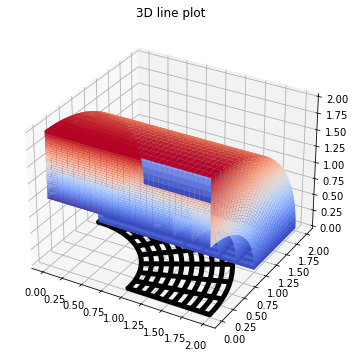

In [43]:
G = geometry.tensor_product(geometry.quarter_annulus(), geometry.line_segment(0,2))
G2 =  geometry.quarter_annulus()
#G = geometry.tensor_product(geometry.line_segment(0,1), geometry.quarter_annulus())
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')
plot_geo(G) #vmin=0.0, vmax=2.5e-2 3D

plot_geo(G2, linewidth=5) #vmin=0.0, vmax=2.5e-2 2D
ax.set_title('3D line plot')
plt.show()

In [44]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 4.5
r_in = 3.7

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]


# 3D
#geos_3d = [geometry.tensor_product(geometry.line_segment(0,1), g) for g in geos]
geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,5)) for g in geos]

In [45]:
Mu = 7.56 * 1e-3  # N/mm²

In [46]:
class multipatch_block_handler:

    # Takes array of multi-patch objects
    def __init__(self, multi_patches):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X, multi_patch.patch_to_global(p)))
        return X

    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                # print(item[3])
                if len(item) < 4 or p in item[3]:
                    data_p.append((item[0], item[1], lambda *x: item[2](*x)[p]))
            if len(data_p) > 0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                # print('bcs_p', bcs_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    # Indices need offset
                    bcs[0] = np.concatenate((bcs[0], bcs_p[0] + offset))
                    # Values are kept as-is
                    bcs[1] = np.concatenate((bcs[1], bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)

    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset

##########################################


In [47]:
## 3D functions
#####################################################

def get_components3d(u, kvs_u):
    """Split solution vector into displacement components."""
    # print("shape_u", shape(u))
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    assert u.shape[0] == 3 * N
    m_u = tuple(kv.numdofs for kv in kvs_u)
    u1 = u[:N].reshape(m_u)
    u2 = u[N:2 * N].reshape(m_u)
    u3 = u[2 * N:3 * N].reshape(m_u)
    U = np.stack((u1, u2, u3), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


###############################################
# Energy functional
def energy3d(u_p, kvs_ux, geo_ux, X):
    Lam = 440.307 * 1e-3  # N/mm²
    dis = get_components3d(X.T @ u_p, kvs_ux)
    e_term = '(.5*( grad(dis).T + grad(dis) + grad(dis).dot(grad(dis).T) ))'
    return sum(assemble.assemble(f'( Lam/2*tr({e_term})*tr({e_term}) + Mu*tr({e_term}.dot({e_term})) ) * aux * dx',
                                 kvs_ux, bfuns=[('aux', 1)], geo=geo_ux, dis=dis, Lam=Lam, Mu=Mu,
                                 idmat=np.identity(3)).ravel())


# Nonlinear variational form
def nonlinear_form3d(u_p, kvs_ux, geo_ux, X):
    Lam = 440.307 * 1e-3  # N/mm²
    dis = get_components3d(X.T @ u_p, kvs_ux)
    e_term = '(.5*( grad(dis).T + grad(dis) + grad(dis).dot(grad(dis).T) ))'
    f_term = '( idmat + grad(dis) )'
    return assemble.assemble(f'inner( ( Lam*tr({e_term})*idmat + 2*Mu* {e_term} ).dot({f_term}), grad(v) ) * dx',
                             kvs_ux, bfuns=[('v', 3)], geo=geo_ux, dis=dis, Lam=Lam, Mu=Mu,
                             idmat=np.identity(3)).ravel()


# Linearized variational form
def linearized_form3d(u_p, kvs_ux, geo_ux, X):
    Lam = 440.307 * 1e-3  # N/mm²
    dis = get_components3d(X.T @ u_p, kvs_ux)
    e_term = '(.5*( grad(dis).T + grad(dis) + grad(dis).T.dot(grad(dis)) ))'
    e_deriv = '(.5*( grad(u).T + grad(u) + grad(u).T.dot(grad(dis)) + grad(dis).T.dot(grad(u)) ))'
    f_term = '( idmat + grad(dis) )'
    f_deriv = 'grad(u)'
    return assemble.assemble(
        f'inner( ( Lam * tr({e_term}) * idmat + 2*Mu*{e_term} ).dot({f_deriv}) + ( Lam * tr({e_deriv}) * idmat + 2*Mu*{e_deriv}).dot({f_term}), grad(v) ) * dx',
        kvs_ux, bfuns=[('u', 3), ('v', 3)], geo=geo_ux, dis=dis, Lam=Lam, Mu=Mu, idmat=np.identity(3))


### mass matrix ###
def ass_mass3d(MP_block):
    first = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy

        M_x = assemble.mass(kvs_ux, geo_ux)
        M_p = scipy.sparse.bmat(
            [[M_x, None, None],
             [None, M_x, None],
             [None, None, M_x]], format='csr')

        if first:
            M = X @ M_p @ X.T
            first = False
        else:
            M += X @ M_p @ X.T

    return M

########################################
# assemble linear system and right-hand side (with Neumann)
def ass_nonlinsystem3d(u, MP_block, neu_data):
    first = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy

        # The whole patch-local stiffness matrix
        A_p = linearized_form3d(u, kvs_ux, geo_ux, X)  # take linearized variatonal form

        # The patch-local Neumann boundary data, right-hand side
        b_p = -nonlinear_form3d(u, kvs_ux, geo_ux, X)

        # Neumann data
        N_e, bdofs = ass_Neumann3d(p, MP_block, neu_data)
        for c in range(3):  # x and y
            offset = MP_block.compute_local_offset_for_component(p, c)
            for i in range(len(bdofs)):
                b_p[bdofs[i] + offset] += N_e[c, i]  # (43,1,2)

        if first:
            A = X @ A_p @ X.T
            b = X @ b_p
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p
            
    return A, b


##############################################################
# assemble linear system and right-hand side (with Neumann)
def ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR):
    A, b = ass_nonlinsystem3d(u, MP_block, neu_data)
    return A + AR, b - AR @ u


##################################################
### assemble Neumann bdc ####

def ass_Neumann3d(p, MP_block, neu_data):
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy
    for item in neu_data:
        if item[0] == p:
           # with function gN
            N_e = assemble.assemble('inner(g,v)*ds', kvs_ux, geo=geo_ux, g=item[2], bfuns=[('v', 3)],symmetric=True, boundary=item[1]).ravel()
            #N_e = -item[3] * assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',3)], geo=geo_ux, g=item[2], boundary=item[1]).ravel()
            N_e = N_e.reshape(3, -1)  # 3dim, -1 remaining factor to get to the total number of elements
            bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
    return N_e, bdofs


### assemble Robin bdc ####

def ass_Robin3d(MP_block, robin_data):
    firstR = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        for item in robin_data:
            if item[0] == p:
                AR_u = item[3] * assemble.assemble('u * v *g*ds', kvs_ux, bfuns=[('u', 1), ('v', 1)], geo=geo_ux,
                                                   g=item[2],  # Here only scalar!
                                                   format='csr', layout='blocked', boundary=item[1])
                bdofs_R = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(3):  # x and y
                    offset = MP_block.compute_local_offset_for_component(p, c)
                    if firstR:
                        AR = X.tocsr()[:, bdofs_R + offset] @ AR_u @ X.tocsr()[:, bdofs_R + offset].T
                        firstR = False
                    else:
                        AR += X.tocsr()[:, bdofs_R + offset] @ AR_u @ X.tocsr()[:, bdofs_R + offset].T
    return AR


#######################
#### rhs + Neumann BC 
def ass_rhs3d(u, MP_block, neu_data):
    first = True

    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]  # kvs_uy, geo_uy

        b_p = -nonlinear_form3d(u, kvs_ux, geo_ux, X)

        N_e, bdofs = ass_Neumann3d(p, MP_block, neu_data)
        for c in range(2):  # x and y
            offset = MP_block.compute_local_offset_for_component(p, c)
            for i in range(len(bdofs)):
                b_p[bdofs[i] + offset] += N_e[c, i]  # (43,1,2)

        if first:
            b = X @ b_p
            first = False
        else:
            b += X @ b_p
            
    return b


#########################################

# for Robin bdc only
##################################
#### rhs + Neumann BC + Robin BC ####
def ass_rhs_RN3d(u, MP_block, neu_data, AR):
    b = ass_rhs3d(u, MP_block, neu_data)
    return b - AR @ u


################################################
# derive energy functional (with Neumann + Robin)
def ass_energy3d(u, MP_block, kvs_j, neu_data=None, robin_data=None):
    j = 0
    for p in range(MP_block.numpatches):  # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        j_p = energy3d(u, kvs_ux, geo_ux, X)
        dis = get_components3d(X.T @ u, kvs_ux)

        j_R = 0  ###!!
        j_N = 0  ###!!

        # Robin-Data
        if robin_data != None:
            for item in robin_data:
                if item[0] == p:
                    # Rg =assemble.assemble('inner(g,aux)*ds', kvs_j, bfuns=[('aux',2)], geo=geo_ux, g=item[2], boundary=item[1])
                    # print(Rg.sum())
                    R_p = item[3] / 2 * assemble.assemble('inner(dis,dis) *g* aux * ds', kvs_j, bfuns=[('aux', 1)],
                                                          dis=dis, geo=geo_ux, g=item[2], boundary=item[1],
                                                          layout='packed')  # first attempt
                    j_R += R_p.sum()
        if neu_data != None:
            for item in neu_data:
                if item[0] == p:
                    #N_e = -item[3]*assemble.assemble('inner(n, dis) * aux * ds', kvs_j, bfuns=[('aux',1)], geo=geo_ux, boundary=item[1], dis=dis)
                    N_e = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v', 1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis)
                    # print('N_e=', N_e)
                    j_N += N_e.sum()

        j += (j_p + j_R - j_N)

    return j

####################################

In [48]:
patches_u = [(kvs_u, g) for g in geos_3d] # 3D

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True) #3D

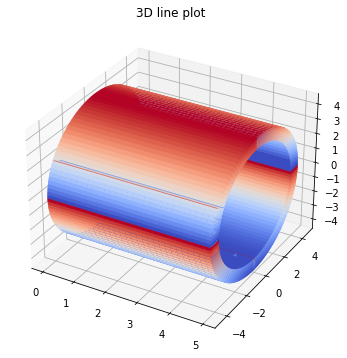

In [49]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

for g in geos_3d:
    plot_geo(g)#, vmin=0, vmax=7.5)

ax.set_title('3D line plot')
plt.show()

In [50]:
# define boundary conditions

In [51]:
# source term f, 3D
def f(x, y, z): return (0.0, 0.0, 0.0)

In [52]:
# not needed! --> use implemented normal vector in assembling routine!
#Neumann BC #
def gN0(x, y, z): 
#quarter annulus in y/z coord.system
    return (0, y/r_in*l_val, z/r_in*l_val) # inner pressure, in normal direction (0, 1, 1)

# quarter annulus in x/y coord.system
   # return (x/r_out*loading_value, y/r_out*loading_value, 0)  #inner  pressure, normalized vector


In [53]:
def g0(x,y,z): #different load over x-axis
    if (x > 1.5).all() and (x < 3.5).all(): # set force at middle only
    #if(x>0).all(): # set force equally over x-axis
        return l_val 
    else:
        return 0

In [54]:
def gN(x, y, z): #different load over x-axis
    #if isinstance(x,numpy.float64):
        #print(x)
    s_y = shape(y)
    fac = [g0(xi,y, z) for xi in np.nditer(x)]
    fac= np.reshape(fac, s_y)
    return (0, y/r_in* fac,z/r_in*fac)# inner pressure

In [55]:
# Multipatch objects for all variables (x, y, z)
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_u] ) 

In [56]:
# define Dirichlet boundary function 
def g_zero(x, y, z): return (0.0, 0.0, 0.0) # fixed in y/z, x runs, evtl. set x=x

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'top', g_zero ) # outer bd, 1
])

In [57]:
# Robin BC
def g_robin(x, y, z): 
    return (1-(y/r_out+ z/r_out)**2) # scalar value
   

In [58]:
# Compute solution of nonlinear elasticity problem

In [59]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [60]:
M = ass_mass3d(MP_block)
Minv = make_solver(M)

use SuperLU


In [61]:
#incremental loading
maxload = 1.5e-3 #for Robin
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [62]:
alpha =1e-2 #1e-2# 1.5e3# 1e0 # 1e4 max penalization!
robin_data = [(1, 'top', g_robin, alpha)] # instead of Dirichlet-bdc, outer bd fixed

In [63]:
# assemble Robin-matrix
AR = ass_Robin3d(MP_block, robin_data)

In [64]:
def J(u):
    return ass_energy3d(u, MP_block, kvs_j, neu_data, robin_data)


def grad_J(u):
    return -ass_rhs_RN3d(u, MP_block, neu_data, AR)


In [65]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 
### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN,l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann

### first iteration ###
A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR) # with Robin-matrix


r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(A).dot(b) 
u += u_d

#A, b = ass_nonlinsystem(u, MP_block, neu_data, AR) 
#print('rhs:', b)
b= ass_rhs_RN3d(u, MP_block, neu_data, AR)
#print('rhs:', b)

r = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual  =', r)
print('Energy    =', J(u))

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###



Residual0 = 0.003521721301137604
Energy0   = 0.0
use SuperLU
Residual  = 57.88639018408143
Energy    = 0.8567386762479481


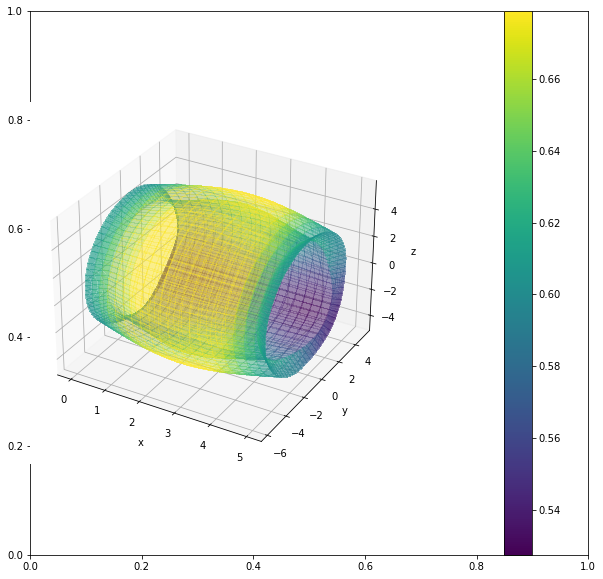

In [66]:
get_defplotC(u, patches_u, kvs_u, MP_u)

In [67]:
def get_defplotpp(u, patches_u, kvs_u, MP_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, **kwargs):
    
    #u= LS.complete(u)
    u1_funcs, u2_funcs, u3_funcs = split_u3d(u, MP_u, kvs_u, patches_u)   
    fig, ax = plt.subplots(figsize= (10,10))
    vrange = None
    x_el = n_el[0]
    y_el = n_el[1]
    z_el = n_el[2]
    count=0
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        print('\n patch:', count)
        
        #res= x_el # or res=20 for better approximation
        if gridz is None: gridz= 1
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][1]/2, supp[2][1]/2, 1) # evaluate in the middle 
            #gridz = np.linspace(supp[2][0], supp[2][1], 2)
            print(supp[2])
            print('grid z:', gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            print(shape(pts))
            
            plt.pcolormesh(pts[..., 1], pts[..., 2], C, shading='gouraud', cmap='viridis', vmin=vrange[0], vmax=vrange[1])
            
            plt.plot(pts[0,0, 1], pts[0,0, 2], 'ro') # inner radius
            plt.plot(pts[0,res-1, 1], pts[0,res-1, 2], 'bo') # outer radius
            radius_inner = np.sqrt( (pts[0,0, 1])**2 + (pts[0,0, 2])**2)
            print('inner_radius: ', radius_inner)

        zgridxy = (meshx, meshy, gridz)

         # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        print('dis=',shape(dis))
        print('displacement_inner= {}'.format(dis[0, 0,...]))
        #print('displacement_y= {}'.format(dis[...,1]))
  
        dis23= np.stack((dis2[...,0], dis3[...,0]), axis=-1) # displacement(y,z) evaluated on 3-dim grid, reduced to 2d 
        #print('displacement_23= {}'.format(dis23))
        #print('first: ',dis23[0,0, 0])#inner y
        #print('second: ',dis23[0,0, 1])# inner z
        #print('first2: ',dis23[0,res-1, 0])# outer y
        #print('second2: ',dis23[0,res-1, 1])# outer z
        #print('displacement_z= {}'.format(dis[...,2]))
        #print('displacement_inner= {}'.format(dis[0,0,0]))
        #print('displacement_inner= {}'.format(dis))
        #print('displacement_outer= {}'.format(dis[0, res-1,...]))
        #print('displacement_outer= {}'.format(dis[0,0,0]))
         #plt.plot(G[i, 0, 0] + dis[0,0, 0], G[i, 0, 1] + dis2[i, 0], 'ro') # inner radius
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])    
             
        G= grid_eval(geo, zgridxy)
        #print('G=',shape(G))
        plt.plot(G[0,0,0, 1], G[0,0,0, 2], 'mo') # inner radius (undeformed)
        plt.plot(G[0,res-1,0, 1], G[0,res-1,0, 2], 'go') # outer radius
        #plt.plot(G[0,0,0, 1] +dis2[0,0,0], G[0,0,0, 2]+dis3[0,0,0], 'mo') # inner radius
        #plt.plot(G[0,res-1,0, 1]+dis2[0,0,0], G[0,res-1,0, 2]+dis3[0,0,0], 'go') # outer radius
        
        ### need for data export!!
        #print( 'dis_inner_y/dis_outer_y: ', dis2[0,0,0]/dis2[0,res-1,0])
        print( 'dis_inner_y/dis_outer_y: ', dis23[0,0, 0]/dis23[0,res-1, 0])
        print( 'dis_inner_z/dis_outer_z: ', dis3[0,0,0]/dis3[0,res-1,0])
        #print( 'dis_inner_z/dis_outer_z: ', dis23[0,0, 1]/dis23[0,res-1, 1])
        
        #radius_inner2 = np.sqrt( (G[0,0,0, 1] +dis2[0,0,0])**2 + (G[0,0,0, 2]+dis3[0,0,0])**2)
        #print('inner_radius_2: ', radius_inner2)
        radius_inner3 = np.sqrt( (G[0,0,0, 1] +dis23[0,0, 0])**2 + (G[0,0,0, 2]+dis23[0,0, 1])**2)
        print('inner_radius_3: ', radius_inner3)
        
        count+=1
      
    plt.colorbar();
    plt.axis('equal')
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    plt.show()


 patch: 0
(0.0, 1.0)
grid z: [0.5]
dis= (20, 20, 1, 3)
displacement_inner= [[1.86739513e-13 5.36106254e-01 3.82525380e-01]]
(20, 20, 3)
inner_radius:  4.2533424340573305
(20, 20, 3)
inner_radius:  4.2533424340573305
dis_inner_y/dis_outer_y:  1.2746671460538508
dis_inner_z/dis_outer_z:  1.425409783920218
inner_radius_3:  4.2533424340573305

 patch: 1
dis= (20, 20, 1, 3)
displacement_inner= [[ 6.30606678e-14 -3.82525380e-01 -5.36106254e-01]]
(20, 20, 3)
inner_radius:  4.253342434054562
(20, 20, 3)
inner_radius:  4.253342434054562
dis_inner_y/dis_outer_y:  1.4254097839078175
dis_inner_z/dis_outer_z:  1.2746671460553254
inner_radius_3:  4.253342434054562

 patch: 2
dis= (20, 20, 1, 3)
displacement_inner= [[ 2.48680243e-12 -1.46493697e+00  3.54584127e-01]]
(20, 20, 3)
inner_radius:  5.177094151513558
(20, 20, 3)
inner_radius:  5.177094151513558
dis_inner_y/dis_outer_y:  1.0922588392394532
dis_inner_z/dis_outer_z:  1.0143226998377293
inner_radius_3:  5.177094151513558

 patch: 3
dis= (20, 2

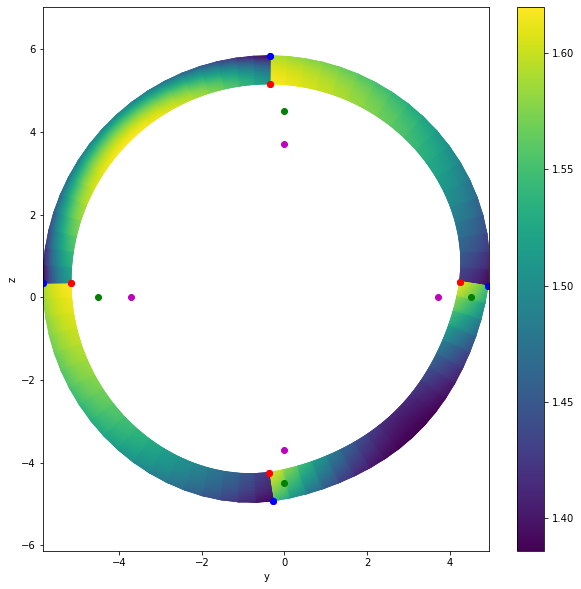

In [68]:
get_defplotpp(u, patches_u, kvs_u, MP_u)

In [ ]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
#M = ass_mass(MP_block)
#Minv = make_solver(M)
r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
#r0 = np.linalg.norm(b)


print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

    count = 0
    while True:
        count+=1

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
            r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
            #r = np.linalg.norm(b)
            print('Residual =',r)
            print('Energy   =',J(u))
        #else: # Use from last iteration; see below (*)
        #    A, b = ass_nonlinsystem_RN(u)
            
        print(count)

        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(A).dot(b)
        u += u_d            

        # Compute new non-linear residual, already to be used for next iteration (*)
        A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm 
        #r= np.linalg.norm(b)
        print('residual =', r)
        print('energy   =', J(u))
        
        #w1 = np.linalg.inv(A.todense()).dot(b)-u  #TODO: Use solver instead of inverse !!! 
        #w1 = make_solver_orig(A).dot(b)-u         #TODO: We do not want to solve that often!!
        #w2 = b - A.dot(u)
        #err= np.sqrt(np.abs(np.inner(w1,w2)))
        #print('Error=', err)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplotC(u, patches_u, kvs_u, MP_u)

In [ ]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [ ]:
s_sol= shape(solutions)[0]

In [ ]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field_3d(fields, patches_u, kvs_u, vrange=None, res=50,cmap=None, interval=50, progress=False):
    """Animate a sequence of scalar fields over a geometry."""
    
    figsize(10,10)
    fig = plt.figure()
    ax = plt.axes(projection ='3d') #,xlim=(0, 2), ylim=(-0.5, 0.5)
    
    fields = list(fields)
    ar= np.linspace(1,20, s_sol)
    factor = ar[0]
    vrange = None

    # first solution
    #u= LS.complete(fields[0])
    u= fields[0]
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    def plotlineC(pts, C, capstyle='butt'):
            #C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            #print(shape(C))
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
    
    def plotline(pts, capstyle='butt'):
            C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            vrange = (C.min(), C.max())
            ax.plot_surface(factor*pts[..., 0], factor*pts[..., 1], factor*pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3, facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            ax.set_xlim3d(left=0, right=5.5)
            ax.set_ylim3d(bottom=-7, top=4.5)
            #ax.set_zlim3d(bottom=-0.5, top=0.5)
            ax.set_zbound(lower=-5.5, upper=5.5)
            
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        
        gridx = np.linspace(supp[0][0], supp[0][1], 2) # e.g. linespace(0, 1, 2)
        gridy = np.linspace(supp[1][0], supp[1][1], 2)
        gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
        
        
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
      
        #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])
        
        
        
        ##'''
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
    vrange = (C.min(), C.max())
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])   
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    #plt.show()
  
    #fig.colorbar(quadmesh, ax=ax);
    #colorbar();
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    def anim_func(i):
        plt.cla()
        
        vrange= None
        factor = ar[i] # choose factor for deformation plot
        u= fields[i]
        #u = LS.complete(fields[i])

        #Split solution vector into displacement components
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:2*MP_u.numdofs]
        u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

        # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]
        u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
               for p in range(len(patches_u))]
        
             # visualization per patch
        for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

            # y-grid 
            dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(ygridxz) #y-value
            dis3 = u3_func.grid_eval(ygridxz) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

            pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
            C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, 0, :], C[:, 0, :])
            for j in range(1, pts.shape[1] - 1):
                plotlineC(pts[:, j, :], C[:, j, :])
            plotlineC(pts[:, -1, :], C[:, -1, :])

            # z-grid
            dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(zgridxy) #y-value
            dis3 = u3_func.grid_eval(zgridxy) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            #vrange = (C.min(), C.max())
            #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])

            pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
            C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, :, 0],C[:, :, 0])
            for k in range(1, pts.shape[2] - 1): 
                plotlineC(pts[:, :, k], C[:, :, k])
            plotlineC(pts[:, :, -1], C[:, :, -1])
        
            pbar.update()
            if i == len(u) - 1:
                pbar.close()
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)

In [ ]:
from IPython.display import HTML

figsize(14, 4)
#fields = [ud_array[tt] for tt in range(s_sol)]
fields = [solutions[tt] for tt in range(s_sol)] ## time steps
HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=535, progress=True).to_html5_video())
#writervideo = animation.FFMpegWriter(fps=15)
#HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=600, progress=True).save('Robin3dc15.mp4', writer=writervideo))

In [ ]:
get_defplotpp(u, patches_u, kvs_u, MP_u)

In [ ]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

### first iteration ###
A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR) # with Robin-matrix


r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(A).dot(b) 
u += u_d

#A, b = ass_nonlinsystem(u, MP_block, neu_data, AR) 
#print('rhs:', b)
b= ass_rhs_RN3d(u, MP_block, neu_data, AR)
#print('rhs:', b)

r = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual  =', r)
print('Energy    =', J(u))

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###


In [ ]:
get_defplotC(u, patches_u, kvs_u, MP_u)

In [ ]:
# Line search based on energy (line search)
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN, l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann

# residuum for max. loadig
b = ass_rhs_RN3d(u, MP_block, neu_data, AR)
r0= np.transpose(b).dot(Minv.dot(b)) #Dual of L2-norm

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

J0 = 0

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN, l_val), (1,'bottom',gN, l_val), (2,'bottom',gN, l_val), (3,'bottom',gN, l_val)] # set neumann
    count= 0
    rejected = False
    
    while True:
        count+=1
        if count == 1:
            # first residuum for incremental loading
            A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
            r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
            #r = np.linalg.norm(b)
            print('Residual =',r)
            print('Energy   =',J(u))
        print(count)


        # Assemble matrices and rhs in every iteration step
        #A, b = ass_nonlinsystem(u, MP_block, neu_data, AR)
        u_d = make_solver(A).dot(b) 
        
        # check if matrix is positive definite in a particular direction u_d
        sp = b.dot(A @ u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))

       ## # # do Wolfe-Powell line search # # ###
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        print('alpha=', alpha)
        
        if alpha == None:           
            print('Use line search based on energy:')
            alpha = 1.
            J1 = J(u+alpha*u_d)
            print("alpha = {} gives energy {}".format(alpha, J1))
            downfactor = .7
            upfactor   = 1.3

            while J1>J0:
                alpha *= downfactor
                J1 = J(u+alpha*u_d)
                print("alpha = {} gives energy {}".format(alpha, J1))
            if alpha == 1.:
                J2 = J(u+upfactor*alpha*u_d)
                print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
                while J2<J1:
                    alpha *= upfactor
                    J1 = J2
                    J2 = J(u+upfactor*alpha*u_d)
                    print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
            print("alpha = {}".format(alpha))
            
        u += alpha * u_d       
            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #Dual of L2-norm
        print('residual = {}'.format(r))
        J0 = J(u)
        print('energy   = {}'.format(J0))
        
        w1 = np.abs(make_solver(A).dot(b)-u)        #TODO: We do not want to solve that often!!
        w2 = np.abs(b - A.dot(u))
        err= np.sqrt(np.inner(w1,w2))
        print('Error=', err)


        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(np.array(u))
    iter_counts.append(count)
        
print("done")

In [ ]:
get_defplotC(u, patches_u, kvs_u, MP_u)

In [ ]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [ ]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [ ]:
s_cts= shape(iter_counts)[0]

In [ ]:
s_sol= shape(solutions)[0]

In [ ]:
figsize(6,3)
fig, ax= plt.subplots()

plot(range(s_cts), iter_counts)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [ ]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

    dis = get_components3d(X.T @ u, kvs_ux)
    detF= sum(assemble.assemble( '(tr(grad(dis))+tr(idmat))  * aux * dx',kvs_ux, bfuns=[('aux',1)], geo=geo_ux, dis=dis, idmat=np.identity(3)).ravel())
    print(detF)